In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

In [11]:
def formatData(file_name):
    df = pd.read_csv(file_name).dropna()
    df = df['Adj Close'].values.reshape(-1, 1)
    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
    
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler.fit_transform(dataset_train)
    dataset_test = scaler.transform(dataset_test)
    return dataset_train, dataset_test, scaler

def create_dataset(df, numOfDataPoints):
    x, y = [], []
    for i in range(numOfDataPoints, df.shape[0]):
        x.append(df[i-numOfDataPoints:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [20]:
dataset_train, dataset_test, scaler = formatData('^TNX.csv')
#data: 50 data points; 1 label
x_train, y_train = create_dataset(dataset_train, 50)
x_test, y_test = create_dataset(dataset_test, 50)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape

(12098, 50, 1)

In [21]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 96)               

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
379/379 [==============================] - 12s 23ms/step - loss: 0.0027
Epoch 2/5
379/379 [==============================] - 8s 22ms/step - loss: 0.0010
Epoch 3/5
379/379 [==============================] - 8s 22ms/step - loss: 9.6264e-04
Epoch 4/5
379/379 [==============================] - 8s 22ms/step - loss: 7.1158e-04
Epoch 5/5
379/379 [==============================] - 10s 26ms/step - loss: 6.2852e-04


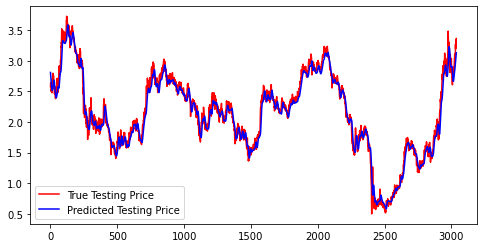

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()